# TODO
#inspect img size and distortion
#save history
#inspect output predictions
#plot learning curve

#look at some of the test images! one is empty
#what about train too...
one of the test images is mislablled!! as a rook, but actually a king? one of the first non-bishop guesses

### prep

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Normalization, Masking
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN

from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2023-05-08 19:16:15.336157: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
#some global variables
path_to_dataset = os.path.join("..","data","chess_pieces_images")
IMG_SIZE = 200 #?
BATCH_SIZE = 16
my_seed = 69 
test_split = 0.3 #will take one third of that as val

class_names = ["bishop", "knight", "pawn", "queen", "rook"]
num_classes = len(class_names)

#### Load Data

In [7]:
#load the data
X_train = image_dataset_from_directory(
        path_to_dataset,
        #label_mode="int",
        labels='inferred',
        class_names = class_names,
        color_mode="rgb",
        seed=my_seed,
        subset="training",
        validation_split=test_split,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True
        )

X_test_and_val = image_dataset_from_directory(
        path_to_dataset,
        #label_mode="int",
        labels='inferred',
        class_names = class_names,
        color_mode="rgb",
        seed=my_seed,
        subset="validation",
        validation_split=test_split,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True
        )

#thanks to https://stackoverflow.com/a/63487037 for cardinality()
X_test_and_val_batches = X_test_and_val.cardinality().numpy()
print(f"\n^that's {X_test_and_val_batches} batches for test and val")

batch_split = np.ceil(2* X_test_and_val_batches / 3) #ceil for more test than val

X_test = X_test_and_val.take(batch_split)
X_val = X_test_and_val.skip(batch_split)

print( f"Using {X_test.cardinality().numpy()} batches for test, and {X_val.cardinality().numpy()} batches for val")

Found 651 files belonging to 5 classes.
Using 456 files for training.
Found 651 files belonging to 5 classes.
Using 195 files for validation.

^that's 13 batches for test and val
Using 9 batches for test, and 4 batches for val


#### take a quick gander

(200, 200, 3)


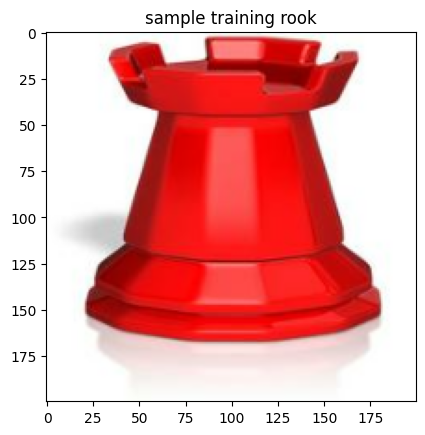

In [12]:
#confirm images are as intended
for image_batch,label_batch in X_train.as_numpy_iterator():
    test_image = image_batch[0]#.numpy()
    test_label = label_batch[0]#.numpy()

    if test_image.any():
        break
        
input_shape = test_image.shape  

plt.imshow(test_image/255)
plt.title(f"sample training {class_names[test_label]}")
print(test_image.shape);

In [13]:
#possible knobs: padding, num pooling layers, num filters, 
#build simple CNN
def build_simple_cnn():

    basic_model = models.Sequential()

    #normalise
    basic_model.add(layers.Rescaling(1./255))

    #Conv layers
    basic_model.add(layers.Conv2D(filters=16, kernel_size=(5,5), padding="same", activation="relu", input_shape=input_shape ))
    basic_model.add(layers.Conv2D(filters=32, kernel_size=(4,4), padding="same", activation="relu"))
    basic_model.add(layers.MaxPool2D(pool_size=(2,2)))
    basic_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))

    #Flatten
    basic_model.add(layers.Flatten())
    
    #Dense layers
    basic_model.add(layers.Dense(128, activation='relu'))
    basic_model.add(layers.Dropout(0.2))
    basic_model.add(layers.Dense(128, activation='relu'))
    basic_model.add(layers.Dropout(0.2))
    basic_model.add(layers.Dense(64, activation='relu'))
    basic_model.add(layers.Dense(64, activation='relu'))
    basic_model.add(layers.Dense(32, activation='relu'))

    #output layer
    basic_model.add(layers.Dense(num_classes, activation="softmax"))
    
    return basic_model
simple_cnn = build_simple_cnn()
simple_cnn

In [14]:
#compile model
#choose loss, optimiser and metrics

def compile_model(model,\
                  loss= "sparse_categorical_crossentropy",\
                  metrics = "accuracy",\
                  optimizer="adam",
                 learning_rate=0.001):
    
    
    #change 'em if you want
    loss= "sparse_categorical_crossentropy"
    metrics = ["accuracy"]
    #optimizer = "adam"
    
    optimizer = Adam(
        learning_rate=learning_rate
    )
    
    
    model.compile(loss=loss, optimizer=optimizer, metrics = metrics)
    
    return model
simple_cnn = compile_model(simple_cnn)

In [16]:
#fit it to training data
def fit_model(model, patience=20, epochs=100):
    epochs = 100
    patience = 25
    es = EarlyStopping(patience=patience, restore_best_weights=True)
    
    history = model.fit(
            X_train,
            validation_data=X_val,
            epochs=epochs,
            #batch_size=BATCH_SIZE,
            callbacks=[es],
            verbose=1
        )  
    
    return history,model
history,model = fit_model(simple_cnn)

Epoch 1/100
29/29 [==============================] - 40s 1s/step - loss: 1.6014 - accuracy: 0.2566 - val_loss: 1.5881 - val_accuracy: 0.2745
Epoch 2/100
29/29 [==============================] - 39s 1s/step - loss: 1.5991 - accuracy: 0.2522 - val_loss: 1.5604 - val_accuracy: 0.3529
Epoch 3/100
29/29 [==============================] - 37s 1s/step - loss: 1.5658 - accuracy: 0.2719 - val_loss: 1.5378 - val_accuracy: 0.2549
Epoch 4/100
29/29 [==============================] - 39s 1s/step - loss: 1.5207 - accuracy: 0.3443 - val_loss: 1.4950 - val_accuracy: 0.3529
Epoch 5/100
29/29 [==============================] - 39s 1s/step - loss: 1.4373 - accuracy: 0.3728 - val_loss: 1.4951 - val_accuracy: 0.3333
Epoch 6/100
29/29 [==============================] - 39s 1s/step - loss: 1.3465 - accuracy: 0.4452 - val_loss: 1.4233 - val_accuracy: 0.3725
Epoch 7/100
29/29 [==============================] - 39s 1s/step - loss: 1.2238 - accuracy: 0.5132 - val_loss: 1.6871 - val_accuracy: 0.3725
Epoch 8/100
2

In [17]:
#predict the test data
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, None, None, None)  0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 16)    1216      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    8224      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 flatten (Flatten)           (None, None)              0         
                                                        

In [19]:
#score?
predictions = model.predict(X_test)

9/9 [==============================] - 2s 165ms/step


In [21]:
#save model
def save_model (model, model_name):
    path_to_models = os.path.join("..","models")
    os.makedirs(path_to_models, exist_ok=True)
    
    if not model_name:
        print("Give the model a name. #goodpractice")
        print("model NOT saved")
        return None
    
    model_path = os.path.join(path_to_models, model_name)
    
    model.save(model_path)
    
    return f"model saved in {path_to_models} as {model_name}"
#save_model(model, "first_ever_model")


INFO:tensorflow:Assets written to: ../models/first_ever_model/assets


INFO:tensorflow:Assets written to: ../models/first_ever_model/assets


'model saved in ../models as first_ever_model'

In [24]:
!ls ../models/first_ever_model/

assets	keras_metadata.pb  saved_model.pb  variables


In [26]:
predictions.shape

(144, 5)

In [30]:
first_prediction = predictions[0]
first_prediction

array([0.2213799 , 0.19668214, 0.17715955, 0.19215633, 0.21262214],
      dtype=float32)

In [54]:
my_predictions = [class_names[np.argmax(prediction)] for prediction in predictions]
my_predictions;

In [38]:
test_images, test_labels = [],[]

for image_batch, label_batch in X_test.as_numpy_iterator():
    for image, label in zip(image_batch, label_batch):
        test_images.append(image)
        test_labels.append(label)
        


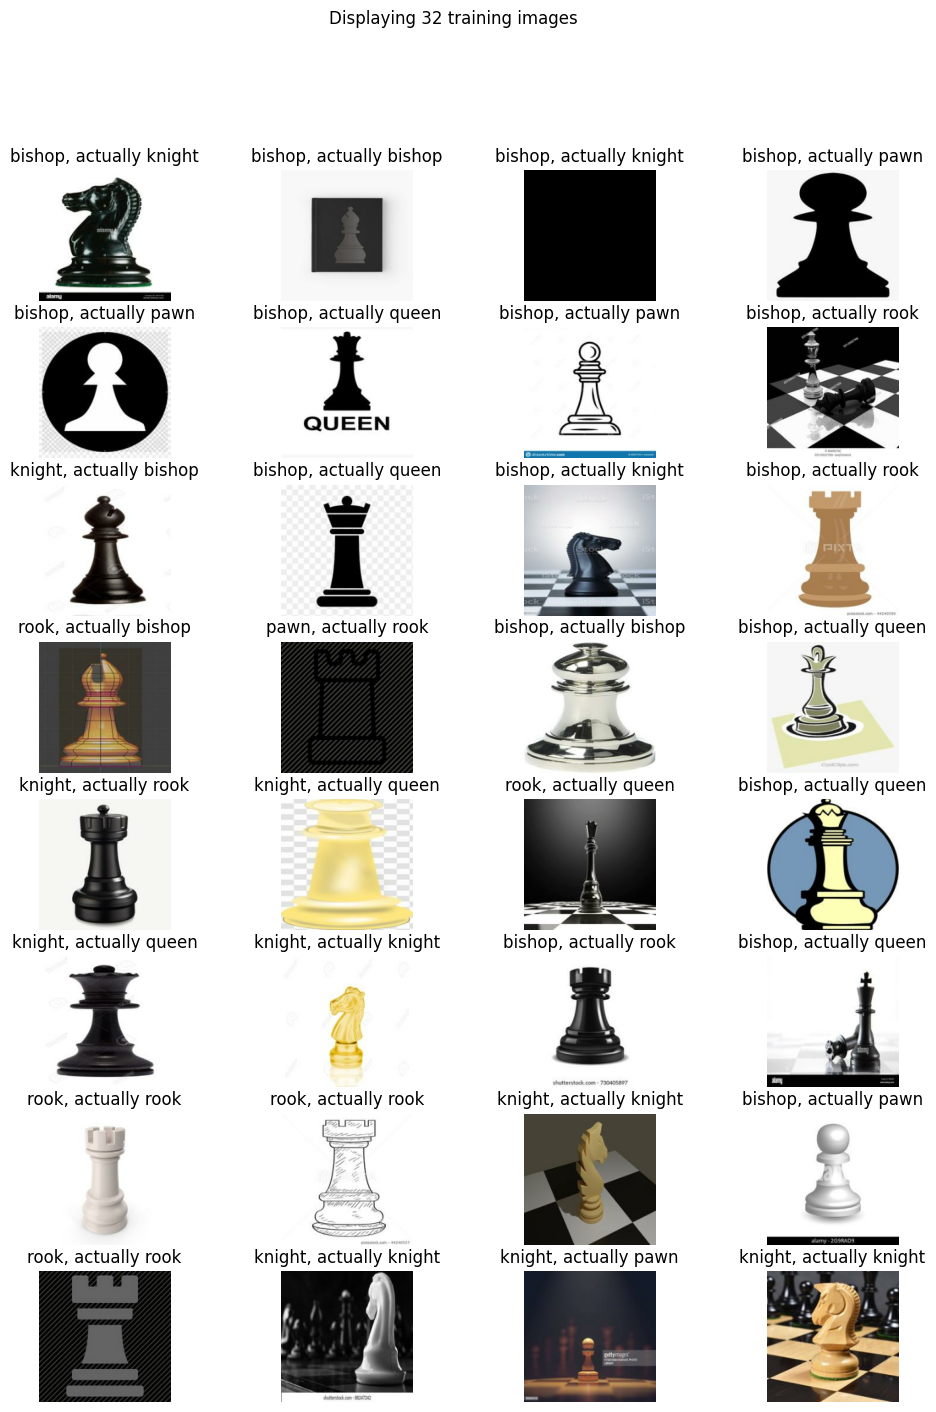

In [64]:
def show_batch_images(image_batch_in, N=8, num_cols=4, predictions=[]):
    
    #see how many batches we will need
    batch_size = 0
    batches = 1
    for batch, labels in image_batch_in:
        batch_size = batch.shape[0]
    if N > batch_size:
        batches = np.ceil(N/batch_size)
    
    #collect images from batch
    images_to_show, labels_to_show = [],[]
    for image_batch, label_batch in image_batch_in.take(batches).as_numpy_iterator():
        #print(image.shape)
        for image, label in zip(image_batch, label_batch):
            if len(labels_to_show) < N:
                images_to_show.append(image)
                labels_to_show.append(label)
    
    num_cols = 4
    num_rows = int(np.ceil(N/num_cols))
    
    #now display them     
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols*3,num_rows*2))
    fig.suptitle(f"Displaying {N} training images")
    
    for i, image in enumerate(labels_to_show):
        x = i % num_cols
        y = i // num_cols
        axs[y,x].axis('off')
        axs[y,x].imshow(images_to_show[i]/255)
        
        piece = class_names[labels_to_show[i] ]
        if predictions:
            pred_piece = predictions[i]
            title = f"{pred_piece}, actually {piece}"
        else:
            title = f"{piece}"
        
        axs[y,x].set_title(title)
    
show_batch_images(X_test, N=32, predictions=my_predictions)

9/9 [==============================] - 1s 150ms/step - loss: 1.4970 - accuracy: 0.3194


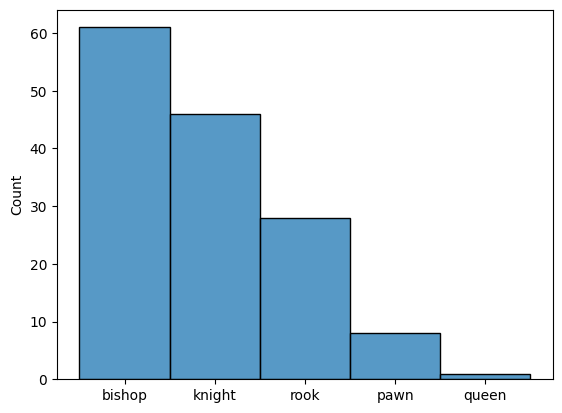

In [66]:
sns.histplot(my_predictions)
evaluation = simple_cnn.evaluate(X_test)

In [70]:
evaluation

[1.496956706047058, 0.3194444477558136]

In [ ]:
#tie it all up in one func